In [1]:
# Script to visualize a reaction family tree

In [1]:
import os
import sys
import copy
import json
import pickle

import numpy as np
import rmgpy.chemkin
import rmgpy.tools.uncertainty

import matplotlib.pyplot as plt
import pydot
import matplotlib.image as mpimg
%matplotlib inline


In [2]:
# Load the RMG mechanism

# Load the base model and the covariance matrix
basedir = '/home/moon/autoscience/autoscience/butane/models/rmg_model'

base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')

species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)

covariance_file = '/home/moon/autoscience/autoscience/uncertainty/butane_covariance.pickle'
with open(covariance_file, 'rb') as handle:
    Sigma_k = pickle.load(handle)


In [3]:
# load the model

uncertainty = rmgpy.tools.uncertainty.Uncertainty(output_directory='rmg_uncertainty')
uncertainty.load_model(base_chemkin, dictionary)




# TODO - force the user to provide the input file used to generate the mechanism to ensure databases are really the same
# load the database
# --------------- CAUTION!!! Databases here must match the ones used to generate the mechanism
# note - this cell stalls out on Discovery
thermo_libs = [
    'BurkeH2O2',
    'primaryThermoLibrary',
    'FFCM1(-)',
    'CurranPentane',
    'Klippenstein_Glarborg2016',
    'thermo_DFT_CCSDTF12_BAC',
    'DFT_QCI_thermo',
    'CBS_QB3_1dHR',
]

kinetic_libs = [
    'FFCM1(-)',
    'CurranPentane',
    'combustion_core/version5',
    'Klippenstein_Glarborg2016',
    'BurkeH2O2inArHe',
    'BurkeH2O2inN2',
]
uncertainty.load_database(
    thermo_libraries=thermo_libs,
    kinetics_families='default',
    reaction_libraries=kinetic_libs,
    kinetics_depositories=['training'],
)


In [4]:
# Get the different kinetic and thermo sources
uncertainty.extract_sources_from_model()
uncertainty.assign_parameter_uncertainties()

In [5]:
# Create a giant dictionary with all of the reaction family information in it
auto_gen_families = {}
for family_name in uncertainty.database.kinetics.families.keys():
    if family_name == 'Intra_R_Add_Endocyclic' or family_name == 'Intra_R_Add_Exocyclic':
        continue
    if uncertainty.database.kinetics.families[family_name].auto_generated and family_name not in auto_gen_families.keys():
        auto_gen_families[family_name] = uncertainty.database.kinetics.families[family_name].rules.get_entries()
        auto_gen_families[f'{family_name}_labels'] = [entry.label for entry in uncertainty.database.kinetics.families[family_name].rules.get_entries()]
        auto_gen_families[f'{family_name}_rxn_map'] = uncertainty.database.kinetics.families[family_name].get_reaction_matches(
            thermo_database=uncertainty.database.thermo,
            remove_degeneracy=True,
            get_reverse=True,
            exact_matches_only=False,
            fix_labels=True)

In [98]:
# for rule in uncertainty.database.kinetics.families[family_name].rules.entries:
#     print(rule)

In [99]:
# for group in uncertainty.database.kinetics.families[family_name].groups.entries:
#     print(group)

# Make the Graph

In [92]:
def get_node_nickname(node):
    parent = node.parent
#     return node.label.split('->')[-1]  # this doesn't work for some reason
    if parent:
        # subtract the length of the parent
        parent_name = node.parent.label
        
        if parent_name != node.label[:len(parent_name)]:
            print(parent_name, node.label)
        return node.label[len(parent_name):]
    return node.label

In [ ]:
# uncertainty.database.kinetics.families[family_name].groups.entries['Root_Ext-1R!H-R'].parent
# uncertainty.database.kinetics.families[family_name].groups.entries['Root'].parent

In [100]:
# get_node_nickname(uncertainty.database.kinetics.families[family_name].groups.entries['Root'])
# get_node_nickname(uncertainty.database.kinetics.families[family_name].groups.entries['Root_Ext-1R!H-R'])
# get_node_nickname(uncertainty.database.kinetics.families[family_name].groups.entries['Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_Ext-4CHNS-R_N-6R!H->S'])

In [48]:
def link_children(parent_node):
    if len(parent_node.children) == 0:
        return
    
    for child in parent_node.children:
        link_children(child)
#         graph.add_edge(pydot.Edge(get_node_nickname(parent_node), get_node_nickname(child), color='black'))  #it's a mess if you do it this way
        graph.add_edge(pydot.Edge(str(parent_node.index), str(child.index), color='black'))



#         graph.add_edge(pydot.Edge(get_node_nickname(parent_node), get_node_nickname(child), color='black'))

# def link_children(parent_node):
#     if len(uncertainty.database.kinetics.families[family_name].groups.entries[parent_node].children) == 0:
#         return
    
#     for child in uncertainty.database.kinetics.families[family_name].groups.entries[parent_node].children:
#         link_children(str(child))
#         graph.add_edge(pydot.Edge(str(parent_node.index), str(child.index), color='black'))

In [94]:
graph = pydot.Dot('Disproportionation_tree', graph_type='digraph', overlap="false")
# graph.set_rankdir('LR')
# graph.set_fontname('sans')
# graph.set_fontsize('10')

# Add nodes
for group in uncertainty.database.kinetics.families[family_name].groups.entries:

    # it's a mess if you do it with nicknames, so use index
#     node_name = get_node_nickname(uncertainty.database.kinetics.families[family_name].groups.entries[group])
#     print(node_name)
#     graph.add_node(pydot.Node(name=node_name))

    if uncertainty.database.kinetics.families[family_name].groups.entries[group].index < 0:
        continue

    graph.add_node(pydot.Node(name=str(uncertainty.database.kinetics.families[family_name].groups.entries[group].index)))
#     print(str(uncertainty.database.kinetics.families[family_name].groups.entries[group].index))

link_children(uncertainty.database.kinetics.families[family_name].groups.entries['Root'])
# link_children('Root')

graph = pydot.graph_from_dot_data(graph.create_dot(prog='dot').decode('utf-8'))[0]

In [ ]:
# change the names of the nodes
for node in graph.get_nodes():
    name = node.get_name()
    for group in uncertainty.database.kinetics.families[family_name].groups.entries:
        if str(uncertainty.database.kinetics.families[family_name].groups.entries[group].index) == name:
            rmgdb_node = uncertainty.database.kinetics.families[family_name].groups.entries[group]
            node.set_label(get_node_nickname(rmgdb_node))
#             print(get_node_nickname())
            break


## Plot the graph

In [96]:
graph.write_dot('Disproportionation_tree.dot')
graph.write_png('Disproportionation_tree.png')

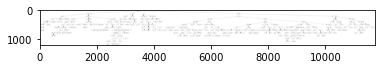

In [97]:
img = mpimg.imread('Disproportionation_tree.png')
imgplot = plt.imshow(img)

In [ ]:
# # some ideas for visualization:
# - size the nodes based on the number of training reactions used
# - size the nodes by uncertainty
# - size the nodes by the number of mechanism reactions that use that node
        